# Третья лабораторная. Методы машинного обучения

Лабораторная состоит из гайда по методам глубинного обучения (Deep Learning) и "продвинутым" методам машинного обучения (Machine Learning) на Python и пяти заданий:

* [Задание 1](#Задание-1.) - поиск гиперпараметров случайного леса

* [Задание 2](#Задание-2.) - поиск гиперпараметров нейросети для классификации

* [Задание 3](#Задание-3.) - поиск гиперпараметров для градиентного бустинга

* [Задание 4 (дополнительное)](#Задание-4-(дополнительное).) - выбор подходящих аугментаций. Это задание повышенной сложности, за него даётся 3 балла

* [Задание 5 (дополнительное)](#Задание-5-(дополнительное).) - выбор модели машинного обучения для решения задачи регрессии. За это задание можно получить 1 балл

Из пяти заданий требуется выполнить минимум первые 3 задания, за остальные задания можно заработать дополнительные баллы.

За попадание в топ 3 по качеству модели в заданиях 3, 4 и 5 можно получить по 1 дополнительному баллу за задание.

Задания 2, 3 и 4 последовательно связаны друг с другом - для одной задачи требуется добиться необходимого качества разными способами. Чтобы выполнить задание 3, требуется сначала выполнить задание 2, так как там обучается нейросеть для предобработки (имейте это в виду, если будете перезапускать ноутбук).

*В этом ноутбуке изначально опущены результаты исполнения кода. Рекомендуется запускать (Shift+Enter) ячейки по мере просмотра документа*

---

## Введение

Центральное понятие в машинном обучении - **модель**. Задачей машинного обучения является создание (обучение) модели, максимально <u>качественно</u> описывающей обучающие <u>данные</u>. Цель - получить модель, способную делать полезные предсказания по новым данным.

При этом критерии <u>качества</u> могут быть различными, и сильно влияют на результирующую модель. Определить *идеальный критерий*, подходящий для любого случая сложно (или невозможно). Это обусловлено как минимум двумя проблемами:
* Данные частично некорректны - содержат шум и выбросы.
    Шум возникает, например, из-за неточности измерений, а выбросы - чаще из-за ошибок; 
* Данные могут быть неполны - не полностью отражать действительность.

Для получения полезной с практической точки зрения модели, надо учитывать, что обучающие данные (training set) могут отличаться от данных, на которых требуется вычислять предсказания (evaluation / test set). 


Как правило задачи машинного обучения разделяют на две категории:

**1. [Обучение без учителя](https://scikit-learn.org/stable/unsupervised_learning.html)**

* [Кластеризация](https://scikit-learn.org/stable/modules/clustering.html);
* [Поиск ассоциативных правил](https://ru.wikipedia.org/wiki/Обучение_ассоциативным_правилам);
* [Понижение размерности](https://scikit-learn.org/stable/modules/unsupervised_reduction.html);
* [Поиск выбросов](https://scikit-learn.org/stable/modules/outlier_detection.html).

**2. [Обучение с учителем](https://scikit-learn.org/stable/supervised_learning.html)**

* [Классификация](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html);
* Регрессия;
* Ранжирование;
* [Анализ выживаемости / рисков](https://nbviewer.jupyter.org/github/sebp/scikit-survival/blob/master/examples/00-introduction.ipynb).

Но также есть множество задач, не вписывающихся в эти категории, например:

* Multiple-instance Learning - целевые значения сопоставлены группам (bag) наблюдений;
* One-shot Learning - классификация с одним обучающим примером для каждого класса;
* Similarity Learning - поиск меры схожести объектов;
* Reinforcement Learning - обучение модели, совершающей действия в ходе взаимодействия со средой;
* Collaborative Filtering - построение рекомендаций;
* Natural Language Processing: машинный перевод, QA - получение текстового ответа на текстовый вопрос;
* Перенос стиля, генерирование изображений.

Поэтому перед созданием модели лучше не сразу пытаться свести задачу к базовым задачам машинного обучения (классификации, регрессии), а поискать модели, использующие специфику области. Например, для машинного перевода специфичен порядок слов в предложении, и правильных переводов может быть несколько - решение задачи без использования этих особенностей приводит к крайне плохим результатам. 

### Overfitting / Underfitting

Чтобы полученная модель была практически применима, надо соблюсти баланс между переобучением (overfitting) и недообучением (underfitting):
* переобучение возникает, когда модель имеет минимальную ошибку на обучающем множестве, и значительно большую на тестовом;
* недообучение возникает при использовании слишком простых моделей, которые не могут обеспечить достаточно маленькую среднюю ошибку даже на тренировочных данных.

В качестве примера рассмотрим задачу одномерной регрессии с синтетическими данными:

Обучающее множество: $\{(x_i, y_i)\}_{i=1}^{n}$,
где $x_i$ - наблюдения $x \sim U([0; 1]); \varepsilon \sim N(0, 0.1)$, 
$y = f(x) + \varepsilon$,

$f(x) = \cos(5 x + \frac{\pi}{2})$

Для простоты будем использовать полиномиальную модель:

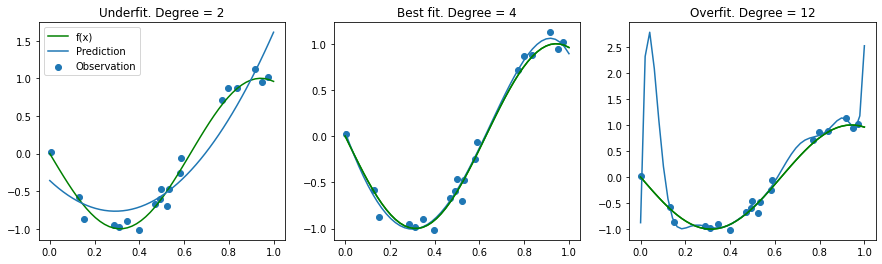

In [41]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(239)

def f(x):
    return np.cos(x * 5 + np.pi/2)

X = np.sort(np.random.rand(20))
y = f(X) + np.random.normal(0, 0.1, len(X))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
X_lin = np.linspace(0, 1, 50)  # массив 50 чисел от 0 до 1
titles = ["Underfit. Degree = 2", "Best fit. Degree = 4", "Overfit. Degree = 12"]
for i, title in enumerate(titles):
    ax[i].set_title(title)
    ax[i].scatter(X, y)  # наблюдения
    ax[i].plot(X_lin, f(X_lin), color='g')  # целевая функция
# модель - полином, подбор коэффициентов - МНК
predictor_underfit = np.poly1d(np.polyfit(X, y, deg=2))
ax[0].plot(X_lin, predictor_underfit(X_lin))

predictor_best = np.poly1d(np.polyfit(X, y, deg=4))
ax[1].plot(X_lin, predictor_best(X_lin))
ax[1].plot(X_lin, f(X_lin), color='g')

predictor_overfit = np.poly1d(np.polyfit(X, y, deg=12))
ax[2].plot(X_lin, predictor_overfit(X_lin))
ax[2].plot(X_lin, f(X_lin), color='g')

ax[0].legend(["f(x)", "Prediction", "Observation"])

plt.show()

Заметим, что третий вариант аппроксимации функции (с переобучением) очевидно не может быть использован на практике. Как минимум, из-за слишком больших значений в промежутке от 0 до 0.1.

Однако о первом варианте (с недообучением) такого сказать нельзя. Хотя полученная функция не совпадает с $f(x)$, она достаточно неплохо оценивает обучающее множество. На практике при малом числе наблюдений и большой размерности пространства сложные модели скорей всего будут склонны к переобучению, тогда как простые, вроде линейной регрессии, будут давать хоть насколько-то верную аппрокимацию.

Посмотрим на ошибки в данном примере на обучающем множестве:

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_err(title, model, x, y_true):
    mse = mean_squared_error(y_true, model(x))
    mae = mean_absolute_error(y_true, model(x))
    r2  = r2_score(y_true, model(x))
    print(title)
    print(f"MSE: {mse:.3f}, MAE: {mae:.3f}, R^2: {r2:.3f}\n")

for i, model in enumerate([predictor_underfit, predictor_best, predictor_overfit]):
    print_err(titles[i], model, X, y)

Underfit. Degree = 2
MSE: 0.060, MAE: 0.206, R^2: 0.894

Best fit. Degree = 4
MSE: 0.007, MAE: 0.068, R^2: 0.987

Overfit. Degree = 12
MSE: 0.005, MAE: 0.045, R^2: 0.992



Здесь $R^2$ - это коэффициент детерминации. Его множество значений от $-\infty$ до $1$.

Эти значения ошибок показывают насколько хорошо модель смогла запомнить обучающие данные.

Попробуем применить модель к новым данным:

In [43]:
X_test = np.sort(np.random.rand(200))
y_test = f(X_test) + np.random.normal(0, 0.1, len(X_test))

for i, model in enumerate([predictor_underfit, predictor_best, predictor_overfit]):
    print_err(titles[i], model, X_test, y_test)

Underfit. Degree = 2
MSE: 0.060, MAE: 0.205, R^2: 0.887

Best fit. Degree = 4
MSE: 0.010, MAE: 0.079, R^2: 0.982

Overfit. Degree = 12
MSE: 0.527, MAE: 0.335, R^2: 0.007



Видно, что качество предсказания первых двух моделей почти не упало, когда как третья (переобученная) даёт ошибку на два порядка больше. Таким образом можно выбрать наиболее корректную модель.

Формально, разность между риском (математическим ожиданием ошибки) и эмпирическим риском (средним значением ошибки на обучающем множестве), называется **переобученностью**.

В примере мы смогли **сгенерировать** новый набор данных, на котором проверяли насколько хорошо подходит модель, **приближая** значение переобученности (вместо математического ожидания ошибки мы вычисляли среднюю, но **не** на обучающем множестве). На практике сгенерировать новый набор данных может быть трудоёмко, или вообще невозможно, поэтому нужно уметь оценивать модель, имея только один (тренировочный) набор данных. Но как?

### Кросс-валидация (Cross-Validation)

Для того, чтобы понять насколько хорошо подходит модель, воспользуемся [перекрёстной проверкой](https://ru.wikipedia.org/wiki/Перекрёстная_проверка) на имеющихся обучающих данных: будем обучать модель $k$ раз, каждый раз выделяя $k-1$ долей обучающего множества для обучения модели (с нуля), используя оставшуюся долю для оценки качества. Это позволит оценить не только качество модели, но и чувствительность к обучающим данным, причём численно.

Часто модели имеют гиперпараметры (параметры, значения которых фиксируются до начала обучения, например количество слоёв в нейронной сети). В примере выше гиперпараметр - это степень полинома. Подберём оптимальные гиперпараметры с помощью C-V. Для этого можно воспользоваться одной из следующих готовых реализаций:
* [Grid-search C-V](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) - перебор значений гиперпараметров на некоторой сетке;
* [Randomized search C-V](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) - перебор случайных значений гиперпараметров;
* [Bayesian C-V](https://scikit-optimize.github.io/notebooks/bayesian-optimization.html) - перебор значений гиперпараметров, используя модифицируемое по ходу представление о форме поверхности ошибки. Реализован в библиотеке [hyperopt](https://hyperopt.github.io/hyperopt/).

Наиболее популярный на данный момент метод - Bayesian C-V, но для простоты рассмотрим классический Grid-search C-V:

In [44]:
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# полиномиальный регрессор - то же самое, что линейная регрессия с признаками (x^0, x^1, x^2, ..., x^k)
polynomial_regressor = make_pipeline(PolynomialFeatures(), LinearRegression())
# сетка параметров степени полинома - целые значения от 0 до 14:
parameters = {'polynomialfeatures__degree': range(15)}

# scoring - минимизируемая метрика: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
search = GridSearchCV(polynomial_regressor, parameters, cv=5, scoring='neg_mean_squared_error')
search.fit(X[:, np.newaxis], y)
print(f"Best loss (-MSE): {search.best_score_}")
print(f"Best parameters: {search.best_params_}")

Best loss (-MSE): -0.13969269572675708
Best parameters: {'polynomialfeatures__degree': 5}


Проблему переобучения также можно решать с помощью регуляризации (например, в случае линейных моделей – Lasso, Ridge). При этом возникают дополнительные параметры, которые имеет смысл также перебирать с помощью кросс-валидации.

## Продвинутые методы машинного обучения

### Ансамблевые методы

Основная идея ансамблевых методов заключается в построении набора различных примитивных базовых моделей и использовании их комбинации для предсказаний.

Это позволяет бороться с двумя проблемами:
1. Переобучение - за счёт различия моделей (структуры или данных, на которых модели обучаются);
2. Низкое качество предсказаний - для большинства моделей за счёт т.н. "мудрости толпы".

В качестве базовых моделей могут использоваться любые методы, от линейной регрессии до нейронных сетей, однако стоит учитывать, что:
* время построения ансамбля сложных моделей будет очень велико. Простые же модели можно строить параллельно;
* на [bias-variance trade-off](https://habr.com/ru/company/ods/blog/323890/#razlozhenie-oshibki-na-smeschenie-i-razbros-bias-variance-decomposition) влияет сложность каждой базовой модели и их количество. Наиболее сложные базовые модели не всегда позволяют получать лучшее качество.

#### 1. Случайный лес

Случайный лес - ансамбль решающих деревьев (построенных по CART). Финальный прогноз производится усреднением результатов работы каждого дерева.

Для получения различных деревьев используются два принципа:
* Bagging (Bootstrap aggregation) - выборка для каждого дерева формируется случайным образом (с возвратом) из тренировочной. Методы, использующие bagging всегда могут оценивать ошибку на "out of bag" элементах начальной выборки - тех, что не вошли ни в одну из подвыборок;
* Random feature subspace - в качестве признаков каждое дерево рассматривает случайное подмножество исходных признаков.

Одним из основных преимуществ случайных лесов для классификации является возможность предсказать не только класс, но и "уверенность" - аппроксимацию вероятности данного класса при условии входных данных. Также они могут применяться для подбора наиболее релевантных признаков - т.н. feature importances.

Рассмотрим простую задачу регрессии Boston House Prices:

In [45]:
from sklearn.datasets import load_boston

boston = load_boston(return_X_y=True)

Все признаки в этом датасете численные. Требуется научиться предсказывать цену дома по его параметрам.

Взглянем на датасет. Понизим размерность с помощью [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) и [Spectral Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html), и поставим цвет, соответствующий значению $y$:

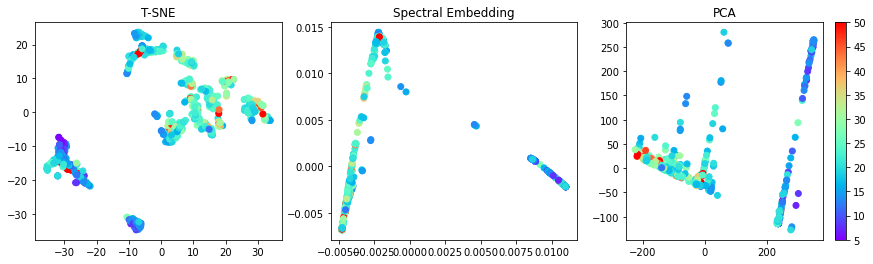

In [46]:
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.decomposition import PCA

boston_X, boston_y = boston

xy = []
xy.append(TSNE(n_components=2).fit_transform(boston_X))
xy.append(SpectralEmbedding(n_components=2).fit_transform(boston_X))
xy.append(PCA(n_components=2).fit_transform(boston_X))

titles = ['T-SNE', 'Spectral Embedding', 'PCA']
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, data in enumerate(xy):
    cx = ax[i].scatter(data[:, 0], data[:, 1], c=boston_y, cmap='rainbow')
    ax[i].set_title(titles[i])
omit = fig.colorbar(cx)

---

#### Задание 1.

В коде ниже приведён пример запуска `RandomForestRegressor`.

Требуется подобрать параметры (кроме `random_state` и `oob_score`) у `RandomForestRegressor`, чтобы [коэффициент детерминации $R^2$](http://www.machinelearning.ru/wiki/index.php?title=Коэффициент_детерминации) (оценка качетва) увеличился на **тестовых данных**, желательно до $0.85$.

_В этом задании и последующих рекомендуется использовать автоматический подбор гиперпараметров вместо того, чтобы подбирать гиперпараметры вручную после каждого обучения модели, которая не смогла достичь требуемого качества._

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


def model_score(X, y, estimator=None, cv=3, scoring=None):
    scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
    return np.mean(scores)


X_train, X_test, y_train, y_test = train_test_split(boston_X, boston_y, test_size=0.25, random_state=12345)

# Ваши значения параметров:
boston_rf = RandomForestRegressor(n_estimators=24,
                                  max_depth=17,
                                  max_features='log2',
                                  min_samples_split=3,
                                  min_samples_leaf=1,
                                  criterion='mse',
                                  
                                  random_state=12345,  # `random_state` оставьте зафиксированным, чтобы можно было
                                                       # повторить ваш результат
                                  oob_score=True)
boston_rf.fit(X_train, y_train)

cv_score = model_score(X_train, y_train, estimator=boston_rf, cv=10, scoring='r2')
train_score = boston_rf.score(X_train, y_train)
test_score = boston_rf.score(X_test, y_test)
oob_score = boston_rf.oob_score_
print("Score (R^2) on train:")
print(f"Out of bag training score estimation: {oob_score}")
print(f"Cross-validation on train score: {cv_score}")
print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Score (R^2) on train:
Out of bag training score estimation: 0.8154924642034327
Cross-validation on train score: 0.8273132762045629
Train score: 0.9718790312269832
Test score: 0.8555098322564632


---

Ещё одной интересной особенностью ансамблей деревьев является возможность подсчитать "*важность*" признаков. Сделаем это для датасета boston:

Топ 3 важных признаков:
RM       average number of rooms per dwelling
LSTAT    % lower status of the population
NOX      nitric oxides concentration (parts per 10 million)


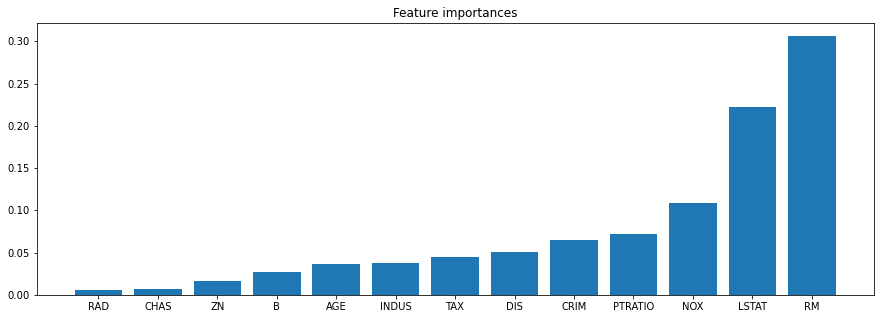

In [48]:
importances = boston_rf.feature_importances_

# достанем названия признаков:
boston_annotation = load_boston()
feature_names = boston_annotation.feature_names
# описания признаков:
descriptions = [val for val in boston_annotation.DESCR.split("\n")
                    if val.find("        -") >= 0]
feature_descriptions = {feature: feature.join(desc.split(feature)[1:])
                        for desc in descriptions
                        for feature in feature_names if desc.find(feature) >= 0}

ind = np.argsort(importances)

plt.figure(figsize=(15, 5))
plt.bar(feature_names[ind], importances[ind])
plt.title("Feature importances")

top_features = list(feature_names[ind][:-4:-1])
print("Топ 3 важных признаков:")
print("\n".join([feature + feature_descriptions[feature] for feature in top_features]))

Помимо того, что *важность* признаков сама по себе может быть полезной информацией для конечного пользователя, на основе неё можно производить автоматический отбор признаков.

Однако следует быть осторожным с использованием такого механизма. Жадная природа алгоритма построения дерева решений может привести к неадекатным значениям такой *важности* признаков. Более надёжных методом (но тоже не идеальным!), подходящим для любых моделей, а не только для лесов, является, например, *permutation importance*.

На практике помимо базового Random Forest также применяют модификации:
* Extra Random Trees - деревья строятся не по алгоритму CART, вместо этого каждое правило деления (split point) выбирается случайным образом, после чего выбирается наиболее релевантный признак. Получается быстрое время построения, но не минимальная ошибка;
* Rotation Random Forest - перед построением каждого дерева к набору предназначенных ему признаков применяется PCA (что означает поворот осей). Такой метод полезно использовать при больших размерностях пространства признаков.

#### 2. [Градиентный бустинг](https://en.wikipedia.org/wiki/Gradient_boosting)

Градиентный бустинг тоже является ансамблевым методом и имеет следующие особенности:
* деревья строятся последовательно - каждая следующая модель старается улучшить ошибку предыдущей, аппроксимируя антиградиент <u>функции потерь</u>;
* результат работы считается как взвешенная сумма результатов базовых моделей, веса которой определяются линейным поиском на этапе построения ансамбля;
* в случае классификации, в сравнении со случайными лесами, градиентный бустинг не позволяет хранить в листьях деревьев классы напрямую. Вместо этого алгоритм находит вероятности классов, как в логистической регрессии. Попробуйте ответить почему это так?

Модели, опирающиеся на градиентный бустинг часто дают наиболее высокое качество, в сравнении со случайными лесами, линейной регрессией, SVM и т.д.
Однако используя градиентный бустинг гораздо легче прийти к переобучению.

Одним из способов борьбы с переобучением является введение скорости обучения `learning rate` - константного множителя для каждой новой базовой модели.

Посмотрим как градиентный бустинг справляется с задачей регрессии на том же датасете:

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

boston_gbm = GradientBoostingRegressor(loss='ls',
                                       learning_rate=0.1,
                                       n_estimators=100,
                                       subsample=.5,  # стохастический бустинг - деревья строятся по случайным подвыборкам
                                       criterion='friedman_mse',
                                       max_depth=3,
                                       max_features='auto',
                                       random_state=12345)
boston_gbm.fit(X_train, y_train)

cv_score = model_score(X_train, y_train, estimator=boston_gbm, cv=10, scoring='r2')
train_score = boston_gbm.score(X_train, y_train)
test_score = boston_gbm.score(X_test, y_test)

print("Score (R^2) on train:")
print(f"Cross-validation on train score: {cv_score}")
print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Score (R^2) on train:
Cross-validation on train score: 0.8933730703147033
Train score: 0.9785371637854611
Test score: 0.8662862211468613


На практике градиентный бустинг из библиотеки sklearn обычно не применяют. Вместо него используют одну из трёх(+) библиотек, в каждой из которых реализованы свои усовершенствования оригинального алгоритма:
* [XGBoost](https://xgboost.readthedocs.io/en/latest/) - первая библиотека, реализующая градиентный бустинг на GPU (2014 год);
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/) - библиотека от Microsoft Research (2017 год), в которой реализована обработка категориальных признаков и усовершенствования производительности;
* **[CatBoost](https://catboost.ai/)** - библиотека от Yandex (2017 год), в которой реализована продвинутая обработка категориальных признаков и методы борьбы с переобучением. Чаще всего в задачах с категориальными признаками CatBoost работает лучше других алгоритмов даже без подстройки параметров, однако чтобы ощутить преимущество следует не применять препроцессинг для категориальных признаков. По словам команды разработчиков, использованный метод построения симметричных деревьев (Oblivious Trees) даёт прирост в качестве во всех случаях. Хотя определяющий фактор для применения таких деревьев – эффективность реализации на GPU.

Установим CatBoost и проверим смелое утверждение разработчиков, не меняя ни одного параметра:

In [50]:
!pip install catboost

In [51]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

boston_catboost = CatBoostRegressor(verbose=False,
                                    allow_writing_files=False,  # не пишем логи, о них ниже
                                    task_type='CPU')  # или 'GPU'
boston_catboost.fit(X_train, y_train, eval_set=(X_test, y_test))

cv_score = model_score(X_train, y_train, estimator=boston_catboost, cv=10, scoring='r2')
train_score = r2_score(y_train, boston_catboost.predict(X_train))
test_score = r2_score(y_test, boston_catboost.predict(X_test))

print("Score (R^2) on train:")
print(f"Cross-validation on train score: {cv_score}")
print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Score (R^2) on train:
Cross-validation on train score: 0.8912408888189314
Train score: 0.9863055615503641
Test score: 0.8551807687648003


#### Визуализация

При обучении моделей градиентного бустинга или сетей очень полезно строить графики функции потерь для тренировочной и тестовой выборок.

*CatBoost* сохраняет логи обучения по умолчанию (если `allow_writing_files == True`) в формат, совместимый с *TensorBoard* и *CatBoost Viewer*. Использовать *TensorBoard* для просмотра логов крайне удобно: достаточно установить *TensorBoard* (`pip install tensorboard`) и запустить его командой `tensorboard --logdir=catboost_info`. Сохранять результаты запусков алгоритма с различными параметрами можно с помощью записи логов в подкаталоги с уникальными именами. С установкой *CatBoostViewer* могут возникнуть небольшие сложности, поскольку он реализован с использованием *NodeJS*.

### Нейронные сети

Если вы планируете использовать нейронные сети, имеет смысл ознакомиться с [этим](https://github.com/abidlabs/AtomsOfDeepLearning/blob/master/Atomic%20Experiments%20in%20Deep%20Learning.ipynb) ноутбуком.

С нейронными сетями чаще всего гораздо сложнее работать, чем с градиентным бустингом: приходится подбирать архитектуру, настраивать огромное число гиперпараметров; нет возможности узнать по какому принципу сеть находит ответ. Однако есть ситуации, в которых нейронные сети просто не имеют адекватно работающих альтернатив:
* обработка изображений, видео - Convolutional NN;
* построение эмбеддинга с учителем и без учителя - AutoEncoder, Siamese NN;
* работа с последовательностями, в том числе генерирование - Recurrent NN и **Transformer**;
* создание генеративных моделей без учителя - Generative Adversarial Networks, Noise Conditional Score Network, и т.д.

Большая часть преимуществ достигается из-за возможности точно управлять целью обучения с помощью функции потерь, а также возможности использовать части обученной сети для решения новой задачи. Например, научив сеть предсказывать корректность словосочетания, можно применять найденный сетью способ кодирования слов для нахождения семантической близости.

#### Кратко о фреймворках

Есть несколько актуальных на данный момент фреймворков для работы с нейронными сетями:
* TensorFlow - построение статических графов вычислений, автоматический вывод градиентов, блоки для построения сетей. Имеет высокий "порог вхождения". С версии `2.0` поддерживает т.н. eager-вычисления, т.е. динамические графы. Обратная совместимость с версиями `1.*` частично отсутствует и может потреобвать переписывания части кода;
* PyTorch - построение динамических графов вычислений, лёгкий перенос вычислений на GPU (требует изменения кода);
* Keras - построение нейронных сетей из блоков. Вычисления производятся с помощью одного из низкоуровневых фреймворков (backend): TensorFlow, CNTK, Theano и др.

Если не требуется реализовывать принципиально новый алгоритм машинного обучения, внедрять наиболее современные механизмы и т.д., проще всего использовать Keras.

Для некоторых архитектур нейронных сетей пишут профильные оптимизированные решения (например, для [YOLO](https://pjreddie.com/darknet/yolo/) - алгоритма быстрого поиска объектов на изображениях реализована низкоуровневая поддержка в библиотеке [Darknet](https://github.com/pjreddie/darknet)). Фреймворки вроде TensorFlow, хоть и обеспечивающие работу с несколькими GPU в кластерах, часто проигрывают по производительности узкопрофильным решениям. На практике, если применяют TensorFlow, как правило используют [оптимизаторы](https://developer.nvidia.com/tensorrt) для ускорения инференса, а для этапа тренировки тратят приличное число ресурсов.


#### Пример

Установим Keras и backend к нему:

**Если у Вас есть GPU с поддержкой CUDA, имеет смысл установить Tensorflow-GPU через conda:
`conda install tensorflow-gpu`** (в таком случае не придётся вручную устанавливать CUDA SDK)

In [52]:
!pip install tensorflow
#! conda install tensorflow-gpu -y
!pip install keras

Построим сеть для решения задачи регрессии, рассмотренной выше.

В Keras удобно строить сеть как последовательность слоёв, для этого используется *Sequential*-модель:

In [53]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation


def make_dense_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1))
    # чтобы модель можно было тренировать, необходимо её скомпилировать
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
    
    return model


dense_model = make_dense_model()

Попробуем натренировать модель примерно до того же качества, что и градиентный бустинг:

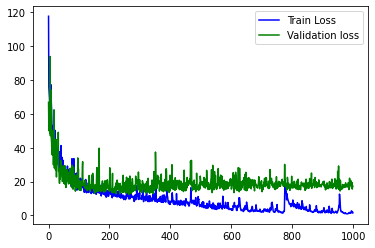

In [54]:
from tensorflow.random import set_seed as set_random_seed
np.random.seed(1)
set_random_seed(1)

n_epochs = 1000

history = dense_model.fit(X_train, y_train,
                          epochs=n_epochs,
                          # число примеров, на которых считается градиент:
                          batch_size=16,
                          validation_data=(X_test, y_test),
                          verbose=False)

plt.plot(range(n_epochs), (history.history['loss']), c='b')
plt.plot(range(n_epochs), (history.history['val_loss']), c='g')
plt.legend(['Train Loss', 'Validation loss'])
plt.show()

Рассмотрим параметры обучения:
* `epochs` - число эпох. Эпоха заканчивается, когда сеть увидела все примеры тренировочного множества;
* `batch_size` - размер мини-батча. В [SGD](http://www.machinelearning.ru/wiki/index.php?title=Стохастический_градиентный_спуск) элементы обучающей выборки разбиваются на группы (мини-батчи) и функция потерь, вместе с её производной, рассчитывается на мини-батчах. Веса обновляются после просмотра каждого мини-батча. Вычислительно выгодней, чтобы мини-батч был достаточно большого размера, поскольку в таком случае данные будут обрабатываться параллельно;
* `validation_data` - данные для построения кривой ошибки на валидационных данных "Validation loss".

По графику функции потерь (loss) можно судить о том, имеет ли смысл обучать сеть большее число итераций.

Посмотрим на качество полученной сети:

In [55]:
train_score = r2_score(y_train, dense_model.predict(X_train))
test_score  = r2_score(y_test, dense_model.predict(X_test))

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.9839577302857129
Test score: 0.7308614102205635


Получить те же результаты можно за меньшее число эпох обучения с помощью стандартизации входных данных.
Так происходит из-за того, что в противном случае сети приходится самой сначала "искать положение данных".

Сделаем предобработку с помощью `StandardScaler` для векторов признаков и `MinMaxScaler` для целевого.
А после каждого полносвязного (`Dense`) слоя поставим `BatchNormalization` - этот механизм стандартизации внутри сети рекомендуется применять почти во всех случаях. Грубо говоря, без него каждый слой сам должен "искать положение" своих входных данных, хотя эту операцию можно сделать явно.

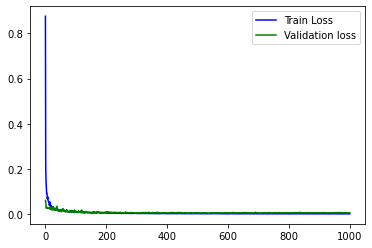

In [56]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.layers import BatchNormalization
np.random.seed(1)
set_random_seed(1)

scaler = StandardScaler()
target_scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train.reshape(y_train.shape[0], 1))
X_test_scaled = scaler.transform(X_test)
y_test_scaled = target_scaler.transform(y_test.reshape(y_test.shape[0], 1))


def make_dense_scaled_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
    
    
dense_scaled_model = make_dense_scaled_model()

history = dense_scaled_model.fit(X_train_scaled, y_train_scaled,
                                 epochs=n_epochs,
                                 batch_size=16,
                                 validation_data=(X_test_scaled, y_test_scaled),
                                 verbose=False)

plt.plot(range(len(history.history['loss'])), history.history['loss'], c='b')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], c='g')
plt.legend(['Train Loss', 'Validation loss'])
plt.show()

In [57]:
def scaled_predict(model, X, target_scaler=target_scaler):
    return target_scaler.inverse_transform(model.predict(X))


train_score = r2_score(y_train, scaled_predict(dense_scaled_model, X_train_scaled))
test_score  = r2_score(y_test, scaled_predict(dense_scaled_model, X_test_scaled))

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.987413468100684
Test score: 0.7963923875390296


---
### Нейронные сети для обработки изображений

Загрузим датасет fashion mnist, содержащий изображения одежды (grayscale 28x28) 10 различных классов:

In [58]:
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = train_images / 255.0
test_images  = test_images / 255.0
train_vectors = to_categorical(train_labels)
test_vectors = to_categorical(test_labels)

Установим keras-tuner для автоматического подбора гиперпараметров

In [59]:
!pip install keras-tuner

Для того, чтобы с помощью `keras-tuner` использовать автоматический подбор гиперпараметров, надо определить функцию, принимающую на вход специальный объект `hp` и возвращающую построенную модель.

У объекта `hp` можно вызывать методы `Choice`, `Int`, `Boolean` и другие для указания, из каких значений перебирать гиперпараметры в данном месте.

Ниже приведён пример кода, где определяется функция `build_model`, которая будет передана "тюнеру" для поиска лучших гиперпараметров.

In [60]:
from keras import Model, Input
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Reshape, GlobalMaxPooling2D,
                          Activation)
import keras_tuner as kt

np.random.seed(1)
set_random_seed(1)

def build_model(hp):
    image_model = Sequential()
    image_model.add(Reshape((28, 28, 1), input_shape=(28, 28)))
    image_model.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    image_model.add(BatchNormalization())
    image_model.add(MaxPooling2D())
    
    # В следующем слое сообщаем keras tuner гиперпараметры, из которых надо искать лучшие
    image_model.add(Conv2D(hp.Int(  # С помощью hp.Int перебираем целые числа в качестве гиперпараметров
                                'second_conv2d_out_channels',  # название нашего гиперпараметра, для которого ищем значение
                                min_value=4,
                                max_value=5,
                                step=1,
                            ),
                           kernel_size=(3, 3), strides=(1, 1),
                           activation=hp.Choice(  # Перебираем значения в качестве гиперпараметров
                               'second_conv2d_activation',  # название нашего гиперпараметра, для которого ищем значение
                               ['relu', 'tanh'],  # список, из которого можно выбирать значения гиперпараметра
                           )))
    
    # Следующий гиперпараметр - "наличие слоя батч-нормализации"
    if hp.Boolean("need_batch_norm_after_second_conv2d"):
        # Сюда зайдём в случае, когда keras-tuner подставит True в качестве гиперпараметра need_batch_norm_after_second_conv2d
        # И тогда в модель будет добавлен слой батч-нормализации
        image_model.add(BatchNormalization())
    
    image_model.add(MaxPooling2D())
    image_model.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    image_model.add(BatchNormalization())
    image_model.add(Flatten())

    image_model.add(Dense(4, activation='relu'))
    image_model.add(Dense(10, activation='softmax'))
    image_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    # Функция должна возвращать построенную и скомпилированную модель
    return image_model

Далее создадим тюнер, который будет искать лучшие гиперпараметры из заданных с помощью случайного поиска (random search).

Случайный поиск используется, когда возможных конфигураций модели слишком много, так как процесс обучения одной модели может быть затратным. При случайном поиске гиперпараметры будут выбираться из возможных случайным образом. Нам нужно лишь указать максимальное количество различных моделей, которые следует обучать.

Лучшими гиперпараметрами тюнер считает модель, которая после обучения показала лучшее качество по метрике, переданной аргументом `objective`.

In [61]:
# Создаём тюнер
tuner = kt.RandomSearch(
    build_model,  # Передаём функцию, определённую выше
    objective='val_loss',  # Передаём критерий качества лучшей модели
    max_trials=3,  # Максимальное кол-во возможных конфигураций, которые тюнер "проверит"
    seed=1234,
)

# Запускаем процесс поиска
# В качестве аргументов передаём всё то, что передали бы в метод fit, если бы подбора гиперпараметров не было
tuner.search(train_images, train_vectors, epochs=5, batch_size=128, validation_data=(test_images, test_vectors))

Trial 4 Complete [00h 00m 36s]
val_loss: 0.6632193326950073

Best val_loss So Far: 0.5674874782562256
Total elapsed time: 00h 01m 48s
INFO:tensorflow:Oracle triggered exit


Посмотрим итоги поиска

In [22]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
second_conv2d_out_channels: 5
second_conv2d_activation: tanh
need_batch_norm_after_second_conv2d: True
Score: 0.5981050729751587
Trial summary
Hyperparameters:
second_conv2d_out_channels: 4
second_conv2d_activation: relu
need_batch_norm_after_second_conv2d: True
Score: 0.6283214092254639
Trial summary
Hyperparameters:
second_conv2d_out_channels: 5
second_conv2d_activation: tanh
need_batch_norm_after_second_conv2d: False
Score: 0.6392688155174255
Trial summary
Hyperparameters:
second_conv2d_out_channels: 5
second_conv2d_activation: relu
need_batch_norm_after_second_conv2d: False
Score: 0.6718057990074158
Trial summary
Hyperparameters:
second_conv2d_out_channels: 5
second_conv2d_activation: relu
need_batch_norm_after_second_conv2d: True
Score: 0.6718057990074158


Создадим модель, которую тюнер признал лучшей

In [62]:
best_model = tuner.get_best_models()[0]  # Создадим модель
best_model.build(input_shape=(None, 28, 28))  # Построим модель с лучшими гиперпараметрами
best_model.summary()  # Посмотрим на архитектуру построенной модели, она соответствует выбранным гиперпараметрам

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 4)        16        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 4)         148       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 4)          0

Замерим `accuracy` для найденной модели на тестовых данных

In [63]:
from sklearn.metrics import accuracy_score

print(f"Качество найденной модели: {accuracy_score(test_labels, np.argmax(best_model.predict(test_images), axis=-1))}")

Качество найденной модели: 0.7893


#### Задание 2.

Измените параметры свёрточной сети / параметры обучения (метода `fit`), чтобы повысить качество (accuracy) на тестовых данных до **0.88**.

При желании можно использовать автоматический подбор гиперпараметров с помощью keras-tuner, но можно обойтись и без него.

In [67]:
import numpy as np
from tensorflow.random import set_seed as set_random_seed
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense, Activation
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Reshape, GlobalMaxPooling2D,
                          Activation)

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images / 255.0
test_images  = test_images / 255.0
train_vectors = to_categorical(train_labels)
test_vectors = to_categorical(test_labels)

np.random.seed(1)
set_random_seed(1)

def build_model(hp):
    class_model = Sequential()
    class_model.add(Reshape((28, 28, 1), input_shape=(28, 28)))
    # далее input_shape указывать не обязательно
    # следует изменить параметры следующих слоёв:
    class_model.add(Conv2D(6, kernel_size=(3, 3), strides=(1, 1),
                           input_shape=(28, 28, 1), activation='relu'))
    class_model.add(BatchNormalization())
    class_model.add(MaxPooling2D())
    class_model.add(Conv2D(6, kernel_size=(3, 3), strides=(1, 1),
                           input_shape=(14, 14, 4), activation='relu'))
    class_model.add(BatchNormalization())
    #class_model.add(MaxPooling2D())
    class_model.add(Conv2D(6, kernel_size=(3, 3), strides=(1, 1),
                           input_shape=(7, 7, 4), activation='relu'))
    class_model.add(BatchNormalization())

    # Слой ниже (и последующие слои) менять не надо
    class_model.add(Flatten(name='flatten'))
    class_model.add(Dense(4, activation='relu'))
    class_model.add(Dense(10, activation='softmax'))
    
    class_model.compile(optimizer='adam', 
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])
    return class_model

tuner1 = kt.RandomSearch(
    build_model,  # Передаём функцию, определённую выше
    objective='val_loss',  # Передаём критерий качества лучшей модели
    max_trials=8,  # Максимальное кол-во возможных конфигураций, которые тюнер "проверит"
    seed=12345,
)

# Запускаем процесс поиска
# В качестве аргументов передаём всё то, что передали бы в метод fit, если бы подбора гиперпараметров не было
tuner1.search(train_images, train_vectors, epochs=5, batch_size=128, validation_data=(test_images, test_vectors))
classification_model = tuner1.get_best_models()[0]

Trial 7 Complete [00h 00m 48s]
val_loss: 0.5001111030578613

Best val_loss So Far: 0.44785556197166443
Total elapsed time: 00h 03m 14s
INFO:tensorflow:Oracle triggered exit


In [78]:
classification_model.compile(optimizer='adam', 
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

classification_model.fit(train_images, train_vectors, epochs=4, batch_size=128,
                         validation_data=(test_images, test_vectors))

Epoch 1/4
469/469 [==============================] - 10s 21ms/step - loss: 0.2587 - accuracy: 0.9063 - val_loss: 0.3653 - val_accuracy: 0.8758
Epoch 2/4
469/469 [==============================] - 9s 20ms/step - loss: 0.2579 - accuracy: 0.9063 - val_loss: 0.3539 - val_accuracy: 0.8832
Epoch 3/4
469/469 [==============================] - 9s 19ms/step - loss: 0.2575 - accuracy: 0.9069 - val_loss: 0.3462 - val_accuracy: 0.8834
Epoch 4/4
469/469 [==============================] - 9s 20ms/step - loss: 0.2589 - accuracy: 0.9053 - val_loss: 0.3558 - val_accuracy: 0.8820


In [72]:
from sklearn.metrics import accuracy_score
def evaluate_model_for_task_2(model):
    test_acc = accuracy_score(test_labels, np.argmax(model.predict(test_images), axis=-1))
    print(f"Качество: {test_acc}")
    print("Тест на качество {}".format("не пройден :(" if 0.88 > test_acc else "пройден :)"))

Вызовите функцию `evaluate_model_for_task_2`, передав ей обученную модель, чтобы увидеть качество этой модели. При сдаче задания качество должно быть не ниже **0.88**

_Примечание: модель, полученная в ходе выполнения этого задания, будет использована далее, поэтому важно, чтобы она называлась_ `classification_model`

In [79]:
#  classification_model = best_model
evaluate_model_for_task_2(classification_model)

Качество: 0.882
Тест на качество пройден :)


---

Посмотрим как выглядит предсказание:

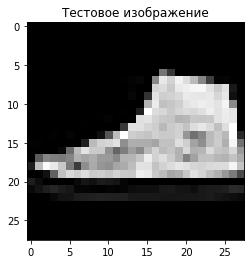

<Figure size 432x288 with 0 Axes>

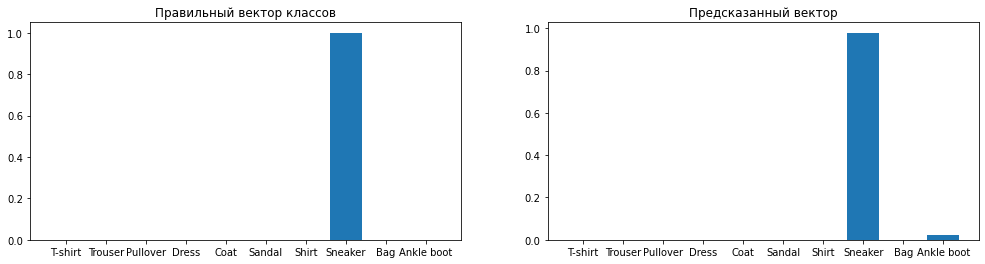

In [80]:
import matplotlib.pyplot as plt
np.random.seed(123456)
test_ind = np.random.randint(test_images.shape[0])
test_image = test_images[test_ind]
test_vector = test_vectors[test_ind]
predicted_test_vector = classification_model.predict(test_image[np.newaxis]).reshape((10,))

plt.imshow(test_image, cmap='gray')
plt.title('Тестовое изображение')
plt.figure()

fig, ax = plt.subplots(1, 2, figsize=(17, 4))
ax[0].bar(range(10), test_vector, tick_label=classes)
ax[1].bar(range(10), predicted_test_vector, tick_label=classes)
for i, title in enumerate(['Правильный вектор классов', 'Предсказанный вектор']): ax[i].set_title(title)

Получим предсказания для первых 100 изображений:

In [81]:
%time
predicted_vectors = classification_model.predict(test_images[:100]).reshape((100, 10))

Wall time: 0 ns


Посмотрим на каких изображениях сеть ошибается:

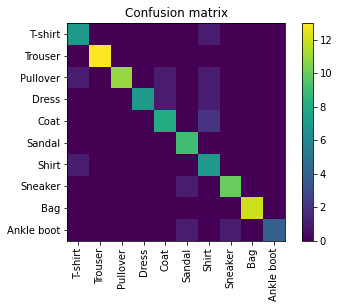

<Figure size 432x288 with 0 Axes>

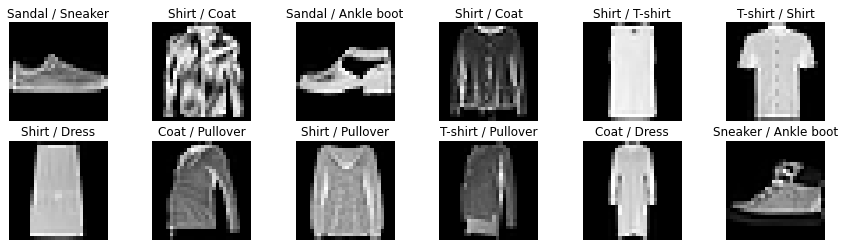

In [82]:
from sklearn.metrics import confusion_matrix

predicted_labels = np.argmax(predicted_vectors, axis=1)  # предсказанные индексы классов - где верояность наибольшая

pred = test_labels[:100] != predicted_labels
misclassified_images = test_images[:100][pred]
misclassified_correct = test_labels[:100][pred]
misclassified_predicted = predicted_labels[:100][pred]

cm = confusion_matrix(test_labels[:100], predicted_labels[:100])
plt.imshow(cm, interpolation='nearest')
plt.xticks(range(10), classes, rotation=90)
plt.yticks(range(10), classes)
plt.colorbar()
plt.title("Confusion matrix")
plt.figure()

fig, ax = plt.subplots(2, 6, figsize=(15, 4))
for i in range(2 * 6):
    ax.flatten()[i].imshow(misclassified_images[i], cmap='gray')
    ax.flatten()[i].axis('off')
    ax.flatten()[i].set_title(f"{classes[misclassified_predicted[i]]} / {classes[misclassified_correct[i]]}")

---

### Gradient Boosting для классификации изображений



Будем рассматривать ту же задачу, что и в прошлом задании.

_Примечание: результатом задания 2 является модель-классификатор_ `classification_model`.

Возьмём лишь часть модели `classification_model` (до полносвязных слоёв), чтобы получить векторы признаков.

In [83]:
# Из слоёв classification_model составим модель для извлечения вектора признаков
feature_extractor = Model(
    inputs=classification_model.inputs,
    outputs=classification_model.get_layer(name="flatten").output,  # Указываем слой, выходы после которого нас интересуют
)

Получим векторы признаков:

In [84]:
train_encoded = feature_extractor(train_images)
test_encoded = feature_extractor(test_images)
print(f'train_encoded.shape = {train_encoded.shape}')
print(f'test_encoded.shape = {test_encoded.shape}')

train_encoded.shape = (60000, 486)
test_encoded.shape = (10000, 486)


---

#### Задание 3.

Для векторов признаков, полученных из предыдущего задания, достроим классификатор на основе градиентного бустинга.

**Требуется:**

Изменить параметры `CatBoostClassifier` ниже, чтобы повысить качество (accuracy), желательно до `0.89`:

In [85]:
dim_reduction = PCA(n_components=train_encoded.shape[-1]) # понизим размерность, используя информацию о классах
small_train_encoded = dim_reduction.fit_transform(train_encoded)
small_test_encoded = dim_reduction.transform(test_encoded)

In [86]:
from catboost import CatBoostClassifier

image_gbm = CatBoostClassifier(loss_function='MultiClass',
                               # эти параметры следует подобрать:
                               depth=6,
                               learning_rate=0.3,
                               iterations=650)
image_gbm.fit(small_train_encoded, train_labels, verbose=0)

In [87]:
image_gbm_labels = image_gbm.predict(small_test_encoded)
image_gbm_score = accuracy_score(test_labels, image_gbm_labels)
print(f"Качество: {image_gbm_score}")

Качество: 0.8917


---

## Аугментация

Часто доступные на этапе обучения размеченные данные оказываются смещёнными, не целиком покрывающими допустимое для данной задачи распределение входных данных.
Также, при использовании нейронных сетей с большим числом параметров, на этапе обучения необходимо большое число различных данных, чтобы модель не деградировала до "табличной функции", запоминая все входные данные.

Для борьбы с обеими проблемами хорошо подходит подход искусственного расширения обучающего набора данных – аугментация. Идея заключается в применении случайных трансформаций к каждому отдельному изображению, при сохранении меток классов. Таким образом можно получить датасет произвольного размера и добиться от нейронной сети определённых свойств (разумеется, для фиксированного, ограниченного распределения входных данных), например: инвариантности к повороту объекта – за счёт обучения на всевозможных поворотах входных изображений.

Важно, что выбор набора трансформаций и распределений из которых генерируются их параметры, специфичен для каждой задачи. Например, при классификации деревьев не разумно выполнять повороты на $\pi$, поскольку известно, что деревья всегда растут снизу вверх.

---

Будем загружать датасет из GoogleDisk, установим библиотеку для удобного скачивания:

In [88]:
!pip install googledrivedownloader

Скачаем файлы с данными:

In [89]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import os

ids_to_file_names = {
    '1iFK4-fCqs8l5lWmYnUYlkv28GDb43FUv': 'fashion_images.npy',
    '15NUcK_Pg4iEUttK1XiG0SonJaEbaaVnI': 'fashion_labels.npy',
    '1AXtbCz3EE2xVuUrGgEco7a-lMh8Vqm0o': 'val_fashion_images.npy',
    '1fk1mZxBLRryWp4IoLHRr5IwiaKy4WL_Y': 'val_fashion_labels.npy',
    '1tWy1d9lkrCzkiSZBlfd1G6YV4sZ7pNt4': 'test_fashion_images.npy',
}

for file_id in ids_to_file_names:
    # Качаем файл только если он ещё не скачан
    if not os.path.isfile(ids_to_file_names[file_id]):
        gdd.download_file_from_google_drive(file_id=file_id,
                                            dest_path=os.path.join('.', ids_to_file_names[file_id]),
                                            unzip=True)

Загрузим данные – изображения 64x64 с цветным шумом и случайно аффинно трансформированными снимками одежды:

In [96]:
fashion_images = np.load("fashion_images.npy")
fashion_labels = np.load("fashion_labels.npy", allow_pickle=True)

val_fashion_images = np.load("val_fashion_images.npy")
val_fashion_labels = np.load("val_fashion_labels.npy")

test_fashion_images = np.load("test_fashion_images.npy")

OSError: Failed to interpret file 'fashion_labels.npy' as a pickle

В качестве тренировочного и валидационного датасета даны изображения и метки (вектора вероятностей классов одежды), в качестве тестового – только изображения.

Ниже дана модель, гиперпараметры которой (количества каналов, размеры ядер, функции активации, архитектуру и т.п.) менять **нельзя**.

In [94]:
def make_fashion_model():
    imodel = Sequential()
    imodel.add(Reshape((64, 64, 3), input_shape=(64, 64, 3)))
    imodel.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(Flatten())

    iclf = Sequential()
    iclf.add(imodel)
    iclf.add(Dense(10, activation='softmax'))

    iclf.compile(optimizer='adam', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return iclf

---

#### Задание 4 (дополнительное).

**Внимание!** Это задание повышенной сложности, за его решение даётся 3 балла, выполнять его необязательно.

Найти такие параметры аугментации (ниже), чтобы качество классификации (accuracy) на тестовых данных было не ниже $0.6$.

*Настоятельно рекомендуется сначала внимательно изучить обучающую и тестовую выборки, а не подбирать параметры случайным образом.*

In [95]:
train_fashion_images = fashion_images.copy()
# здесь можно сделать предварительную обработку всего обучающего датасета
train_fashion_labels = fashion_labels

NameError: name 'fashion_labels' is not defined

In [31]:
from keras.preprocessing.image import ImageDataGenerator

# здесь следует изменить параметры аугментации:
aug = ImageDataGenerator(featurewise_center=True,
                   samplewise_center=True,
                   featurewise_std_normalization=False,
                   samplewise_std_normalization=False,
                   rotation_range=0,
                   width_shift_range=0.0,
                   height_shift_range=0.0,
                   brightness_range=None,
                   shear_range=0.0,
                   zoom_range=0.0,
                   channel_shift_range=0.0,
                   fill_mode='wrap',
                   horizontal_flip=False,
                   vertical_flip=False,
                   rescale=None)

Из параметров обучения можно менять `batch_size` и `epochs`, но использовать можно не больше 200 эпох.

In [32]:
batch_size = 32
fashion_clf = make_fashion_model()

aug.fit(train_fashion_images)
gen = aug.flow(train_fashion_images, train_fashion_labels,
               batch_size=batch_size)

hist = fashion_clf.fit(gen,
               steps_per_epoch=len(train_fashion_images) // batch_size,
               epochs=200,
               validation_data=(val_fashion_images, val_fashion_labels))

NameError: name 'make_fashion_model' is not defined

0.14000000059604645

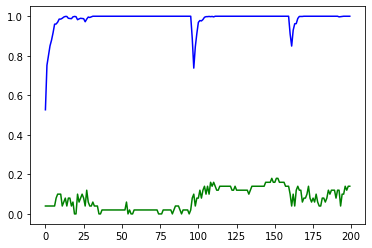

In [76]:
def plot_accuracy(history):
    acc = 'acc' if 'acc' in history else 'accuracy'
    val_acc = 'val_' + acc
    
    plt.plot(range(len(history[acc])), history[acc], color='b')
    plt.plot(range(len(history[val_acc])), history[val_acc], color='g')

    return hist.history[val_acc][-1]

plot_accuracy(hist.history)

Для проверки сохраняются веса сети, а также предсказания для тестовых данных:

In [77]:
fashion_clf.save("fashion_model.h5")

test_predictions = fashion_clf.predict(test_fashion_images)
np.save("submission", test_predictions)

Файлы `fashion_model.h5` и `submission.npy` необходимо добавить в репозиторий вместе с решением.

Любые попытки получить более точную модель не с помощью аугментации запрещены.

---

## Выбор подходящей модели машинного обучения

Возьмём набор данных `wine`

In [3]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

wine_x, wine_y = load_wine(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(wine_x, wine_y, test_size=0.2, random_state=123456)

---

#### Задание 5 (дополнительное).

Подберите модель машинного обучения для решения задачи _регрессии_ на данных из датасета `wine`.

Обучите выбранную модель, используя для обучения только данные `x_train`, `y_train`.

Данные `x_test`, `y_test` можно использовать в обучении _только в качестве валидационных данных_.

Метрика MAE (mean absolute error, средняя квадратическая ошибка) на тестовых данных (`x_test`, `y_test`) должна быть меньше `0.1`.

_За выполнение этого задания можно получить 1 дополнительный балл, но выполнять это задание не обязательно_

In [26]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation


def make_dense_model():
    model = Sequential()
    model.add(Dense(128, input_dim=x_train.shape[1]))
    model.add(Activation('tanh'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(1))
    # чтобы модель можно было тренировать, необходимо её скомпилировать
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
    
    return model

wine_regressor = make_dense_model()
history = wine_regressor.fit(x_train, y_train,
                          epochs=1000,
                          # число примеров, на которых считается градиент:
                          batch_size=8,
                          #validation_data=(X_test, y_test),
                          verbose=False)

In [27]:
from sklearn.metrics import mean_absolute_error

print(f"MAE on test data = {mean_absolute_error(y_test, wine_regressor.predict(x_test))}")

MAE on test data = 0.02921211553944482


---